# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle, glob
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')’’
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

device = 'cuda'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [3]:
kfold_test = None
kfold_clust = 10
ts_batch_size = int(3e4)

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_False
Read metadata from disk.
number of samples in the training set: 1077
number of samples in the testing set: 264


In [4]:
from hots.layer import hotslayer
from tqdm import tqdm
from hots.timesurface import timesurface
from hots.utils import entropy
import numpy as np
import matplotlib.pyplot as plt
import torch, os
import pickle


class network_pooling(object):

    def __init__(self,  name,
                        dataset_name,
                        timestr, # date of creation of the network 
                        sensor_size, # 
                        nb_neurons = (4,8,16), # architecture of the network (default=Lagorce2017)
                        # parameters of time-surfaces and datasets
                        tau = (1e1,1e2,1e3), #time constant for exponential decay in millisec
                        R = (2,4,8), # parameter defining the spatial size of the time surface
                        homeo = True, # parameters for homeostasis (None is no homeo rule)
                        to_record = False,
                        record_path = '../Records/',
                        device = 'cuda',
                ):
        assert len(nb_neurons) == len(R) & len(nb_neurons) == len(tau)
        
        self.name = f'{timestr}_{dataset_name}_{name}_{homeo}_{nb_neurons}_{tau}_{R}'
        nb_layers = len(nb_neurons)
        self.n_pola = [nb_neurons[L] for L in range(nb_layers-1)]
        self.n_pola.insert(0,2)
        # pooling
        self.channel_size = [(sensor_size[0]//(2*R[L]+1)+1, sensor_size[1]//(2*R[L]+1)+1) for L in range(nb_layers-1)]
        self.channel_size.insert(0,(sensor_size[0], sensor_size[1]))
        self.tau = tau
        self.R = R
        self.record_path = record_path
        
        # pooling
        for L in range(nb_layers):
            assert (2*self.R[L]+1)**2 <= self.channel_size[L][0]*self.channel_size[L][1]
        
        path = self.record_path+'networks/'+self.name+'.pkl'
        if os.path.exists(path):
            with open(path, 'rb') as file:
                my_network = pickle.load(file)
            self.layers = my_network.layers
            for L in range(len(self.layers)):
                self.layers[L] = self.layers[L].to(device)
            
        else:
            self.layers = [hotslayer((2*R[L]+1)**2*self.n_pola[L], nb_neurons[L], homeostasis=homeo, device=device) for L in range(nb_layers)]
            
    def clustering(self, loader, ordering, filtering_threshold = None, ts_batch_size = None, device = 'cuda', record = False):
        path = self.record_path+'networks/'+self.name+'.pkl'
        if not os.path.exists(path):
            p_index = ordering.index('p')
            x_index = ordering.index('x')
            y_index = ordering.index('y')
            
            for L in range(len(self.tau)):
                self.layers[L] = self.layers[L].to(device)
                self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
            
            if record:
                entropy = []
                loss = []
                delta_w = []
                homeostasis = []

            with torch.no_grad():
                
                if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
                
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if record:
                        previous_dic = [self.layers[L].synapses.weight.data.T.detach().clone() for L in range(len(self.tau))]
                    if ts_batch_size and len(events)>ts_batch_size:
                        nb_batch = len(events)//ts_batch_size+1
                        for L in range(len(self.tau)):
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch):
                                print(L, self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L], 2*self.R[L]+1,2*self.R[L]+1)
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, _ = self.layers[L](all_ts, True)
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_filtered_timesurface+load_nb*ts_batch_size]) if ind_outputs.shape[0]>0 else ind_filtered_timesurface
                                if record:
                                    proto_ts = all_ts.detach().clone()
                                    kernels = self.layers[L].synapses.weight.data.T
                                    DIFF = 0
                                    for ev in range(len(n_star)):
                                        proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                        diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                        DIFF += diff.mean()
                                    DIFF/=len(n_star)
                                    loss.append(DIFF.cpu())
                                    entropy.append(entropy(kernels))
                                    delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                    homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                            events[:,x_index] = events[:,x_index]//(2*self.R[L]+1)
                            events[:,y_index] = events[:,y_index]//(2*self.R[L]+1)
                            if events.shape[0]==0: break
                    else:    
                        for L in range(len(self.tau)):
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, _  = self.layers[L](all_ts, True)
                            if record:
                                proto_ts = all_ts.detach().clone()
                                kernels = self.layers[L].synapses.weight.data.T
                                DIFF = 0
                                for ev in range(len(n_star)):
                                    proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                    diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                    DIFF += diff.mean()
                                DIFF/=len(n_star)
                                loss.append(DIFF.cpu())
                                entropy.append(entropy(kernels))
                                delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                            del all_ts
                            torch.cuda.empty_cache()
                            
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events[:,x_index] = events[:,x_index]//(2*self.R[L]+1)
                            events[:,y_index] = events[:,y_index]//(2*self.R[L]+1)
                            if events.shape[0]==0: break

            with open(path, 'wb') as file:
                pickle.dump(self, file, pickle.HIGHEST_PROTOCOL)
            if record:
                path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
                with open(path, 'wb') as file:
                    pickle.dump([loss, entropy, delta_w, homeostasis], file, pickle.HIGHEST_PROTOCOL)
            
            
    def coding(self, loader, ordering, classes, training, ts_batch_size = None, filtering_threshold = None, jitter=(None,None), layer_threshold = None, device = 'cuda', verbose=True):
        
        #homeostatic gain control is used only for the clustering phase
        for L in range(len(self.tau)):
            self.layers[L].homeo_flag = False
            self.layers[L] = self.layers[L].to(device)
            self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
        
        if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
        if not layer_threshold: layer_threshold = [None for L in range(len(self.tau))]
        
        p_index = ordering.index('p')
        x_index = ordering.index('x')
        y_index = ordering.index('y')
        
        if training:
            output_path = self.record_path+f'output/train/{self.name}_{len(loader)}_{jitter}/'
        else: output_path = self.record_path+f'output/test/{self.name}_{len(loader)}_{jitter}/'
        
        if os.path.exists(output_path):
            if verbose:
                print(f'this dataset have already been processed, check at: \n {output_path}')
        else:
            for classe in classes:
                os.makedirs(output_path+f'{classe}')
            
            with torch.no_grad():
                nb = 0
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if ts_batch_size and len(events)>ts_batch_size:
                        nb_batch = len(events)//ts_batch_size+1
                        for L in range(len(self.tau)):
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, ind_filtered_layer = self.layers[L](all_ts, False)
                                ind_to_keep = ind_filtered_timesurface[ind_filtered_layer]
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_to_keep+load_nb*ts_batch_size]) if ind_outputs.shape[0]>0 else ind_to_keep
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                            events[:,x_index] = events[:,x_index]//(2*self.R[L]+1)
                            events[:,y_index] = events[:,y_index]//(2*self.R[L]+1)
                            if events.shape[0]==0: 
                                complete_flag = False
                                break
                            else:
                                complete_flag = True
                    else:
                        for L in range(len(self.tau)):
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, ind_filtered_layer = self.layers[L](all_ts, False)
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events = events[ind_filtered_layer,:]
                            events[:,x_index] = events[:,x_index]//(2*self.R[L]+1)
                            events[:,y_index] = events[:,y_index]//(2*self.R[L]+1)
                            del all_ts
                            torch.cuda.empty_cache()
                            if events.shape[0]==0: 
                                complete_flag = False
                                break
                            else:
                                complete_flag = True
                    if complete_flag:
                        np.save(output_path+f'{classes[target]}/{nb}', events)
                    nb+=1
                    
                    
    def plotlayers(self, maxpol=None, hisiz=2, yhis=0.3):
        '''
        '''
        N = []
        P = [2]
        R2 = []
        kernels = []
        for L in range(len(self.tau)):
            kernels.append(self.layers[L].synapses.weight.data.T.cpu().numpy())
            N.append(int(kernels[L].shape[1]))
            if L>0:
                P.append(int(kernels[L-1].shape[1]))
            R2.append(int(kernels[L].shape[0]/P[L]))
        if maxpol is None:
            maxpol=P[-1]

        fig = plt.figure(figsize=(16,9))
        gs = fig.add_gridspec(np.sum(P)+hisiz, np.sum(N)+len(self.tau)-1, wspace=0.05, hspace=0.05)
        if self.layers[-1].homeo_flag:
            fig.suptitle('Unsupervised clustering with homeostasis', size=20, y=0.95)
        else:
            fig.suptitle('Unsupervised clustering for original HOTS', size=20, y=0.95)

        for L in range(len(self.tau)):
            ax = fig.add_subplot(gs[:hisiz, int(np.sum(N[:L]))+1*L:int(np.sum(N[:L+1]))+L*1])
            plt.bar(np.arange(N[L]), (self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu(), width=1, align='edge', ec="k")
            ax.set_xticks(())
            ax.set_title('Layer '+str(L+1), fontsize=16)
            plt.xlim([0,N[L]])
            yhis = 1.1*max(self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu()
            plt.ylim([0,yhis])

            for k in range(N[L]):
                vmaxi = max(kernels[L][:,k])
                for j in range(P[L]):
                    if j>maxpol-1:
                        pass
                    else:
                        axi = fig.add_subplot(gs[j+hisiz,k+1*L+int(np.sum(N[:L]))])
                        krnl = kernels[L][j*R2[L]:(j+1)*R2[L],k].reshape((int(np.sqrt(R2[L])), int(np.sqrt(R2[L]))))

                        axi.imshow(krnl, vmin=0, vmax=vmaxi, cmap=plt.cm.plasma, interpolation='nearest')
                        axi.set_xticks(())
                        axi.set_yticks(())
        plt.show()
        return fig
    
    def plotlearning(self, width_fig = 30):
        path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
        with open(path, 'rb') as file:
            loss, entropy, delta_w, homeostasis = pickle.load(file)
            
        n_layers = len(self.tau)
        fig, axs = plt.subplots(n_layers,4, figsize=(width_fig,n_layers*width_fig//4))
        for L in range(n_layers):
            loss_layer = loss[L::n_layers]
            entropy_layer = entropy[L::n_layers]
            delta_w_layer = delta_w[L::n_layers]
            homeostasis_layer = homeostasis[L::n_layers]
            axs[L,0].plot(loss_layer)
            axs[L,1].plot(entropy_layer)
            axs[L,2].plot(delta_w_layer)
            axs[L,3].plot(homeostasis_layer)
            if L == 0:
                axs[L,0].set_title('average loss')
                axs[L,1].set_title('average entropy values for the time surfaces')
                axs[L,2].set_title('average gradient of the weights')
                axs[L,3].set_title('average homeostasic gain')
        plt.show()

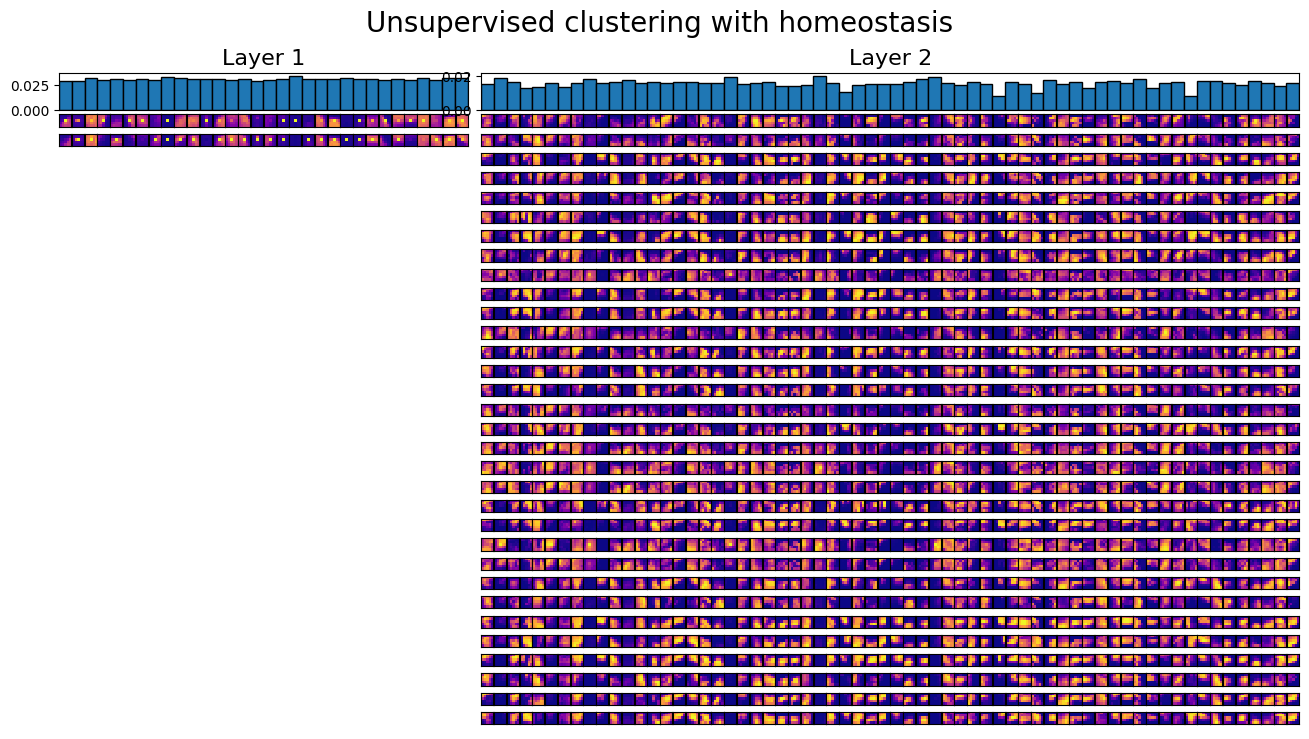

  0%|                                                                                                                                                                                                                                                 | 0/264 [00:00<?, ?it/s]/tmp/ipykernel_2901195/3141971146.py:191: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  events[:,x_index] = events[:,x_index]//(2*self.R[L]+1)
/tmp/ipykernel_2901195/3141971146.py:192: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for ne

In [ ]:
name = 'homeohots'
homeo = True
timestr = '2023-01-04'
dataset_name = 'gesture'

Rz = [2, 2]
N_neuronz = [32, 64]
layer_threshold = [0.05, 0.1]
tauz = [5e3*2, 5e3*N_neuronz[0]]#/(2*Rz[0]+1)**2]

hots = network_pooling(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = None, device = device)
    
hots.plotlayers();
    
jitter = (None, None)

hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, layer_threshold = layer_threshold, training=True, ts_batch_size = ts_batch_size, verbose=False, device = device)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, layer_threshold = layer_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False, device = device)

num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e3*64
drop_proba = .95

ts_batch_size = 300

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

In [ ]:
tau = 5e3*2 
events, target = next(iter(trainloader))
file_name = f'DVS128_{target}_{tau}_{events.shape[1]}'
file_name = f'DVS128_tensor([6])_58068'
make_and_display_ts(events.squeeze(0), file_name, trainset, tau, polarity= 'off', nb_frames = 100, ts_batch_size = int(1e4), device = 'cuda')

In [ ]:
make_and_display_ts(events.squeeze(0), file_name, trainset, tau, polarity= 'on', nb_frames = 100, ts_batch_size = int(1e4), device = 'cuda')

In [ ]:
past_trainings = glob.glob(glob.escape(model_path[:-10])+'*')
if len(past_trainings)==1:
    print(past_trainings)
    with open(past_trainings[0], 'rb') as file:
        classif_layer, mean_loss_epoch = pickle.load(file)

In [ ]:
plt.plot(mean_loss_epoch, '*')

In [ ]:
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}_it14.pkl'
mlr_threshold = None
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

In [ ]:
plt.semilogx(onlinac)

In [ ]:
num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
sensor_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e3*64
drop_proba = .95

ts_size = (31,31)
ts_batch_size = int(1e4)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, sensor_size, trainset.ordering, len(trainset.classes), ts_size = ts_size, ts_batch_size = ts_batch_size, drop_proba = drop_proba)

In [ ]:
plt.plot(losses, '*')

In [ ]:
mlr_threshold = None
ts_batch_size = int(1e3)
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

In [ ]:
plt.semilogx(onlinac)

In [ ]:
mlr_threshold = .9
ts_batch_size = int(1e3)
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

In [ ]:
128//5
